# Score-Based Generative Model: Merton SDE

**Author:** Bilal Saleh Husain

---

This notebook implements the score-based generative modelling pipeline for the Merton structural model.
Two complementary approaches learn the score $s(x,t) = \nabla_x \log p_t(x)$:

1. **Score-PINN** ($s_\phi$): physics-informed, learns the score directly from the Fokker-Planck PDE — no simulation data required.
2. **Empirical Score Network** ($s_\theta$): data-driven, trained via Denoising Score Matching (DSM) on synthetic path data.

Both score functions drive the reverse-time SDE mapping prior samples $X_T \sim p_T$ back toward the initial condition $X_0 \approx x_0$.
A three-way comparison against the closed-form analytical score serves as the validation benchmark.

## Setup and Imports

In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent / 'src'))

from pinn_sgm.equations import FokkerPlanckMertonND
from pinn_sgm.nets import MLP
from pinn_sgm.solvers.score_pinn_solver import ScorePINNSolver
from pinn_sgm.config import ScorePINNConfig, TrainingConfig
from pinn_sgm.sgm import MertonSDE, DSMConfig, DSMTrainer, ReverseDiffusionSampler
from pinn_sgm.visualizations import setup_publication_style, plot_training_history

setup_publication_style()
%config InlineBackend.figure_format = 'retina'

In [2]:
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## Part 1: Mathematical Framework

### 1.1 Merton Model

**Forward SDE**: Asset log-returns follow:
$$
dX_t = \mu\, dt + \Sigma\, dW_t, \quad X_0 = x_0
$$
where $\mu \in \mathbb{R}^n$ is the drift and $\Sigma \in \mathbb{R}^{n \times n}$ is the volatility matrix.

**Fokker-Planck Equation**: The probability density $p(x,t)$ satisfies:
$$
\frac{\partial p}{\partial t} + \mu \cdot \nabla p - \frac{1}{2}\sum_{ij} D_{ij} \frac{\partial^2 p}{\partial x_i \partial x_j} = 0
$$
where $D = \Sigma\Sigma^\top$.

**Analytical solution**: $p(x, t) = \mathcal{N}(x;\, x_0 + \mu t,\, Dt)$

**Score function**: $s(x, t) = \nabla_x \log p(x, t) = -(Dt)^{-1}(x - x_0 - \mu t)$

**Prior at $t = T$**: $p_T = \mathcal{N}(x_0 + \mu T,\; DT)$

### 1.2 Denoising Score Matching

**Denoising Score Matching (DSM)** trains $s_\theta(x, t) \approx \nabla_x \log p_t(x)$ by minimising:
$$
\mathcal{L}_{\mathrm{DSM}}(\theta) = \mathbb{E}_{t,\, x(0),\, x(t)\mid x(0)}
\left[\left\| s_\theta(x(t), t) - \nabla_{x(t)} \log p(x(t) \mid x(0)) \right\|^2\right]
$$
The target $\nabla_{x(t)} \log p(x(t)\mid x(0)) = -(Dt)^{-1}(x(t) - x(0) - \mu t)$ is available in closed form for the Merton SDE.

**Training data** (`x0_data`): All paths start from the fixed point $x_0$. To calibrate to real market data, replace `x0_data` with observed log-returns — no other code change is needed.

### 1.3 Reverse-Time SDE

The **reverse-time SDE** (Song et al., Eq. 6) is:
$$
dX_t = \bigl[f(X_t, t) - G(t)G(t)^\top s(X_t, t)\bigr]\,dt + G(t)\,d\bar{W}_t
$$
where $\bar{W}_t$ is a backward Brownian motion and $s(x,t)$ is the score.

We run this from $t=T$ to $t=t_\epsilon$ with a **Predictor-Corrector** scheme:
- **Predictor**: reverse Euler-Maruyama step
- **Corrector**: Langevin MCMC step(s) at each time point

Starting from prior samples $X_T \sim \mathcal{N}(x_0 + \mu T, DT)$, output should cluster near $x_0 = 0$.

## Part 2: Model Setup

### 2.1 Equation & Forward SDE

We work in 1D for easy visualisation. Changing `spatial_dim` runs the same pipeline in higher dimensions.

In [ ]:
# --- Model parameters ---
spatial_dim = 1
mu    = np.array([0.05])
sigma = np.array([0.2])
x0    = np.zeros(spatial_dim)

T     = 1.0
t_eps = 0.01   # Minimum time; avoids score singularity at t=0
x_min, x_max = -1.0, 1.0  # Spatial domain

# --- Equation ---
equation = FokkerPlanckMertonND(
    spatial_dim=spatial_dim,
    mu=mu,
    sigma=sigma,
    x0=x0,
    device=device,
)

# --- SGM forward SDE wrapper ---
merton_sde = MertonSDE(equation)

D = equation.D.cpu().numpy()
prior_mean = x0 + mu * T
prior_var  = D * T

print(f"Spatial dim   : {spatial_dim}")
print(f"Drift μ       : {mu}")
print(f"Diffusion D   : {D.flatten()}")
print(f"Initial state : x₀ = {x0}")
print(f"Prior at T={T} : N({prior_mean.flatten()}, {prior_var.flatten()})")

### 2.2 Forward Paths

We simulate E-M paths to visualise the forward diffusion and to generate training data $x_0$ for the DSM trainer.

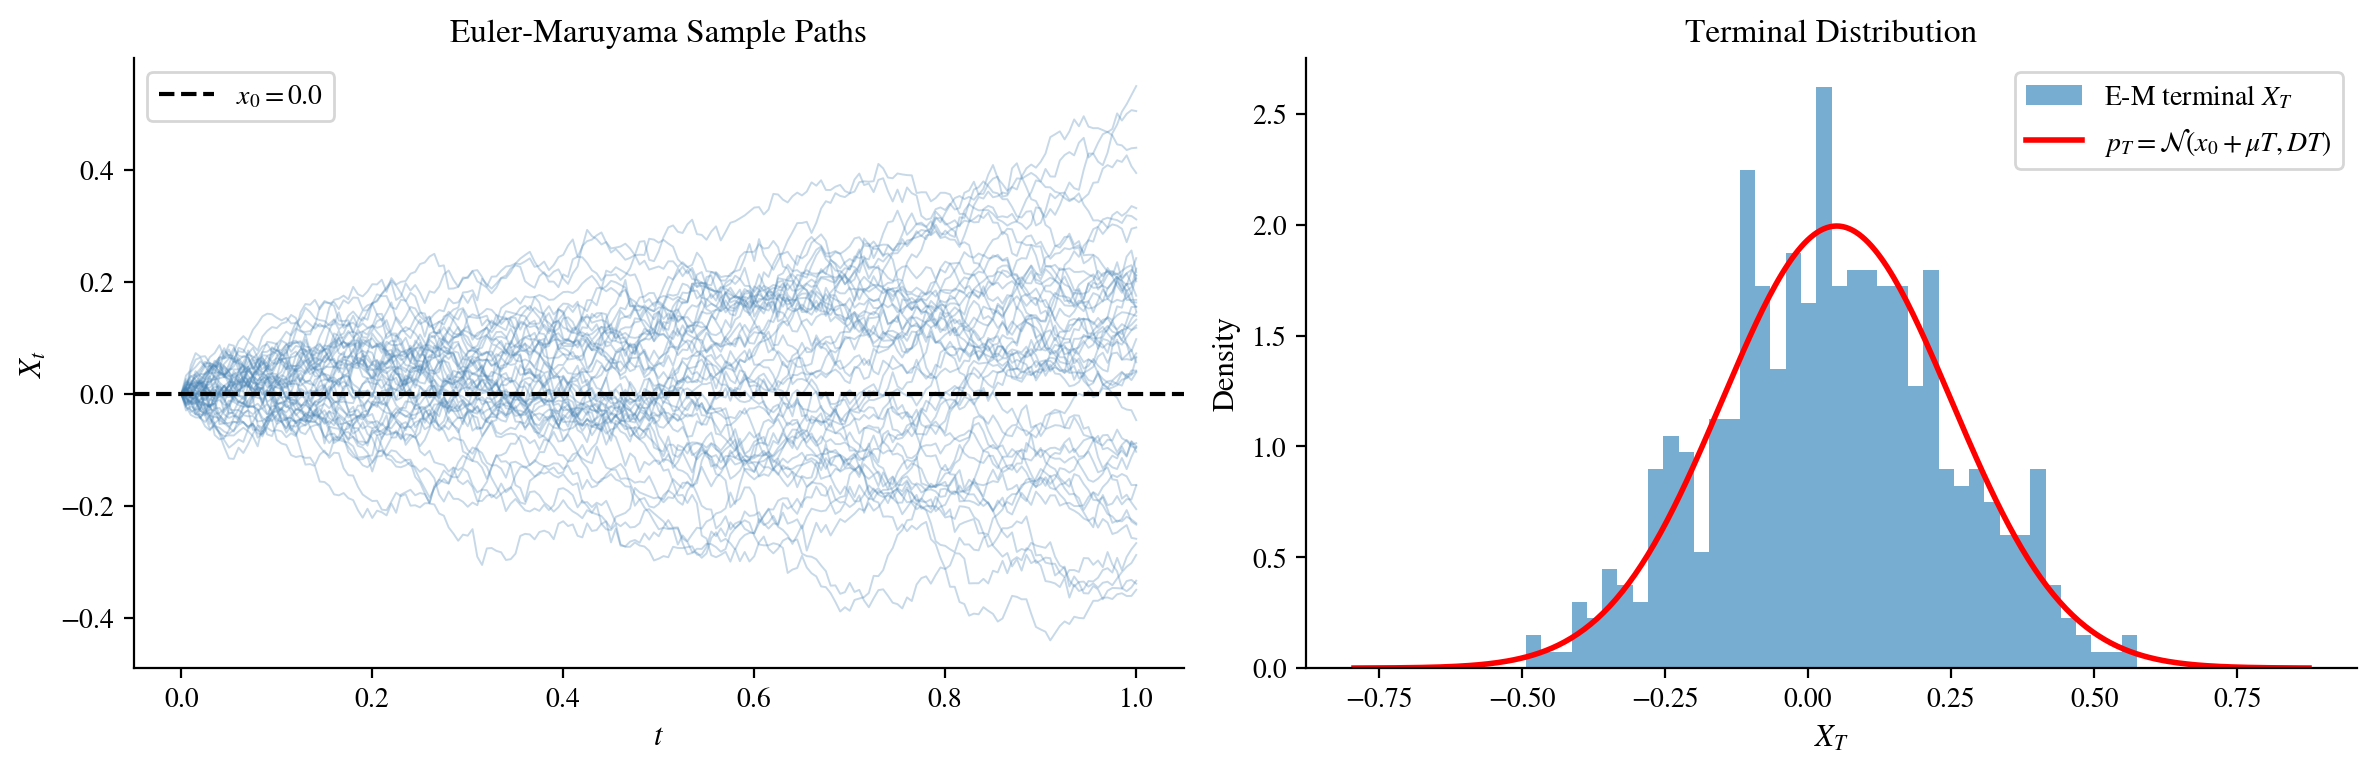

Path tensor shape: torch.Size([500, 201, 1])


In [4]:
N_PATHS  = 500
N_STEPS  = 200

x0_tensor = torch.tensor(x0, dtype=torch.float32, device=device)

paths = merton_sde.simulate_paths(
    x0=x0_tensor,
    T=T,
    n_steps=N_STEPS,
    n_paths=N_PATHS,
    seed=0,
)  # [N_PATHS, N_STEPS+1, d]

time_grid = np.linspace(0, T, N_STEPS + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Left: sample paths ---
ax = axes[0]
paths_np = paths[:50, :, 0].cpu().numpy()   # 50 paths, 1D
for p in paths_np:
    ax.plot(time_grid, p, alpha=0.3, lw=0.7, color='steelblue')
ax.axhline(x0[0], color='k', lw=1.5, linestyle='--', label=f'$x_0={x0[0]}$')
ax.set_xlabel('$t$')
ax.set_ylabel('$X_t$')
ax.set_title('Euler-Maruyama Sample Paths')
ax.legend()

# --- Right: terminal distribution vs prior ---
ax = axes[1]
x_T_samples = paths[:, -1, 0].cpu().numpy()
ax.hist(x_T_samples, bins=40, density=True, alpha=0.6, label='E-M terminal $X_T$')

xgrid = np.linspace(x_T_samples.min() - 0.3, x_T_samples.max() + 0.3, 300)
from scipy.stats import norm
pdf_prior = norm.pdf(xgrid, loc=prior_mean[0], scale=prior_var[0, 0] ** 0.5)
ax.plot(xgrid, pdf_prior, 'r-', lw=2, label=r'$p_T = \mathcal{N}(x_0+\mu T, DT)$')
ax.set_xlabel('$X_T$')
ax.set_ylabel('Density')
ax.set_title('Terminal Distribution')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Path tensor shape: {paths.shape}")

## Part 3: Score Learning

### 3.1 Score-PINN ($s_\phi$)

The Score-PINN learns $s_\phi(x,t) \approx \nabla_x \log p_t(x)$ by solving the score PDE derived from the Fokker-Planck equation. This is a theory-only approach: no simulation data is required — only the SDE coefficients.

The network minimises:
$$
\mathcal{L}(\phi) = \lambda_{\mathrm{IC}}\,\mathcal{L}_{\mathrm{IC}} + \lambda_{\mathrm{PDE}}\,\mathcal{L}_{\mathrm{PDE}}
$$
where $\mathcal{L}_{\mathrm{IC}}$ enforces the known score at $t = t_\varepsilon$ and $\mathcal{L}_{\mathrm{PDE}}$ enforces the score evolution equation. See `score_pinn_nd_analysis.ipynb` for the full derivation.

In [ ]:
# --- Score-PINN network ---
# Input: [x, t] ∈ ℝ^(d+1), Output: score s(x,t) ∈ ℝ^d
score_pinn_net = MLP(
    input_dim=spatial_dim + 1,
    output_dim=spatial_dim,
    hidden_dims=[64, 64, 64],
    activation='tanh',
).to(device)

n_params = sum(p.numel() for p in score_pinn_net.parameters())
print(f"Score-PINN parameters: {n_params:,}")

In [ ]:
# --- Score-PINN config ---
score_pinn_config = ScorePINNConfig(
    n_collocation=5000,
    n_initial=2000,
    batch_size=256,
    lambda_initial=1.0,
    lambda_residual=1.0,
    x_range=(x_min, x_max),
    t_range=(0.0, T),
    method='score_pinn',
    use_hte=True,         # Hutchinson Trace Estimation
    n_hte_samples=1,
)

# --- Training config ---
score_pinn_training = TrainingConfig(
    epochs=5000,
    learning_rate=1e-3,
    lr_scheduler='step',
    lr_decay_step=2000,
    lr_decay_rate=0.5,
    optimizer='adam',
    gradient_clip_val=10.0,
    verbose=True,
    log_interval=1000,
)

# --- Solver ---
score_pinn_solver = ScorePINNSolver(
    equation=equation,
    score_network=score_pinn_net,
    config=score_pinn_config,
    device=device,
)

print(f"Solver Configuration:")
print(f"  Collocation: PDE={score_pinn_config.n_collocation:,}, IC={score_pinn_config.n_initial:,}")
print(f"  Loss weights: λ_IC={score_pinn_config.lambda_initial}, λ_PDE={score_pinn_config.lambda_residual}")
print(f"  Using HTE: {score_pinn_config.use_hte}")
print(f"  Training: {score_pinn_training.epochs:,} epochs, LR={score_pinn_training.learning_rate}")

### 3.2 Training

In [7]:
history_spinn = score_pinn_solver.train(score_pinn_training)


Epoch        Total        Initial      Residual     LR           Time        
------------------------------------------------------------------------
0/5000       2.1690e+04   2.1690e+04   3.0641e-03   1.0000e-03   18.40it/s   
1000/5000    7.3128e+03   7.2812e+03   3.1613e+01   1.0000e-03   26.58it/s   
2000/5000    2.9127e+03   2.8837e+03   2.8917e+01   5.0000e-04   27.32it/s   
3000/5000    2.1451e+03   2.1034e+03   4.1634e+01   5.0000e-04   27.86it/s   
4000/5000    1.3617e+03   1.3416e+03   2.0123e+01   2.5000e-04   28.23it/s   
------------------------------------------------------------------------
Training completed in 176.92s (2.95min)
Final: Total=1.1541e+03, Initial=1.1408e+03, Residual=1.3319e+01



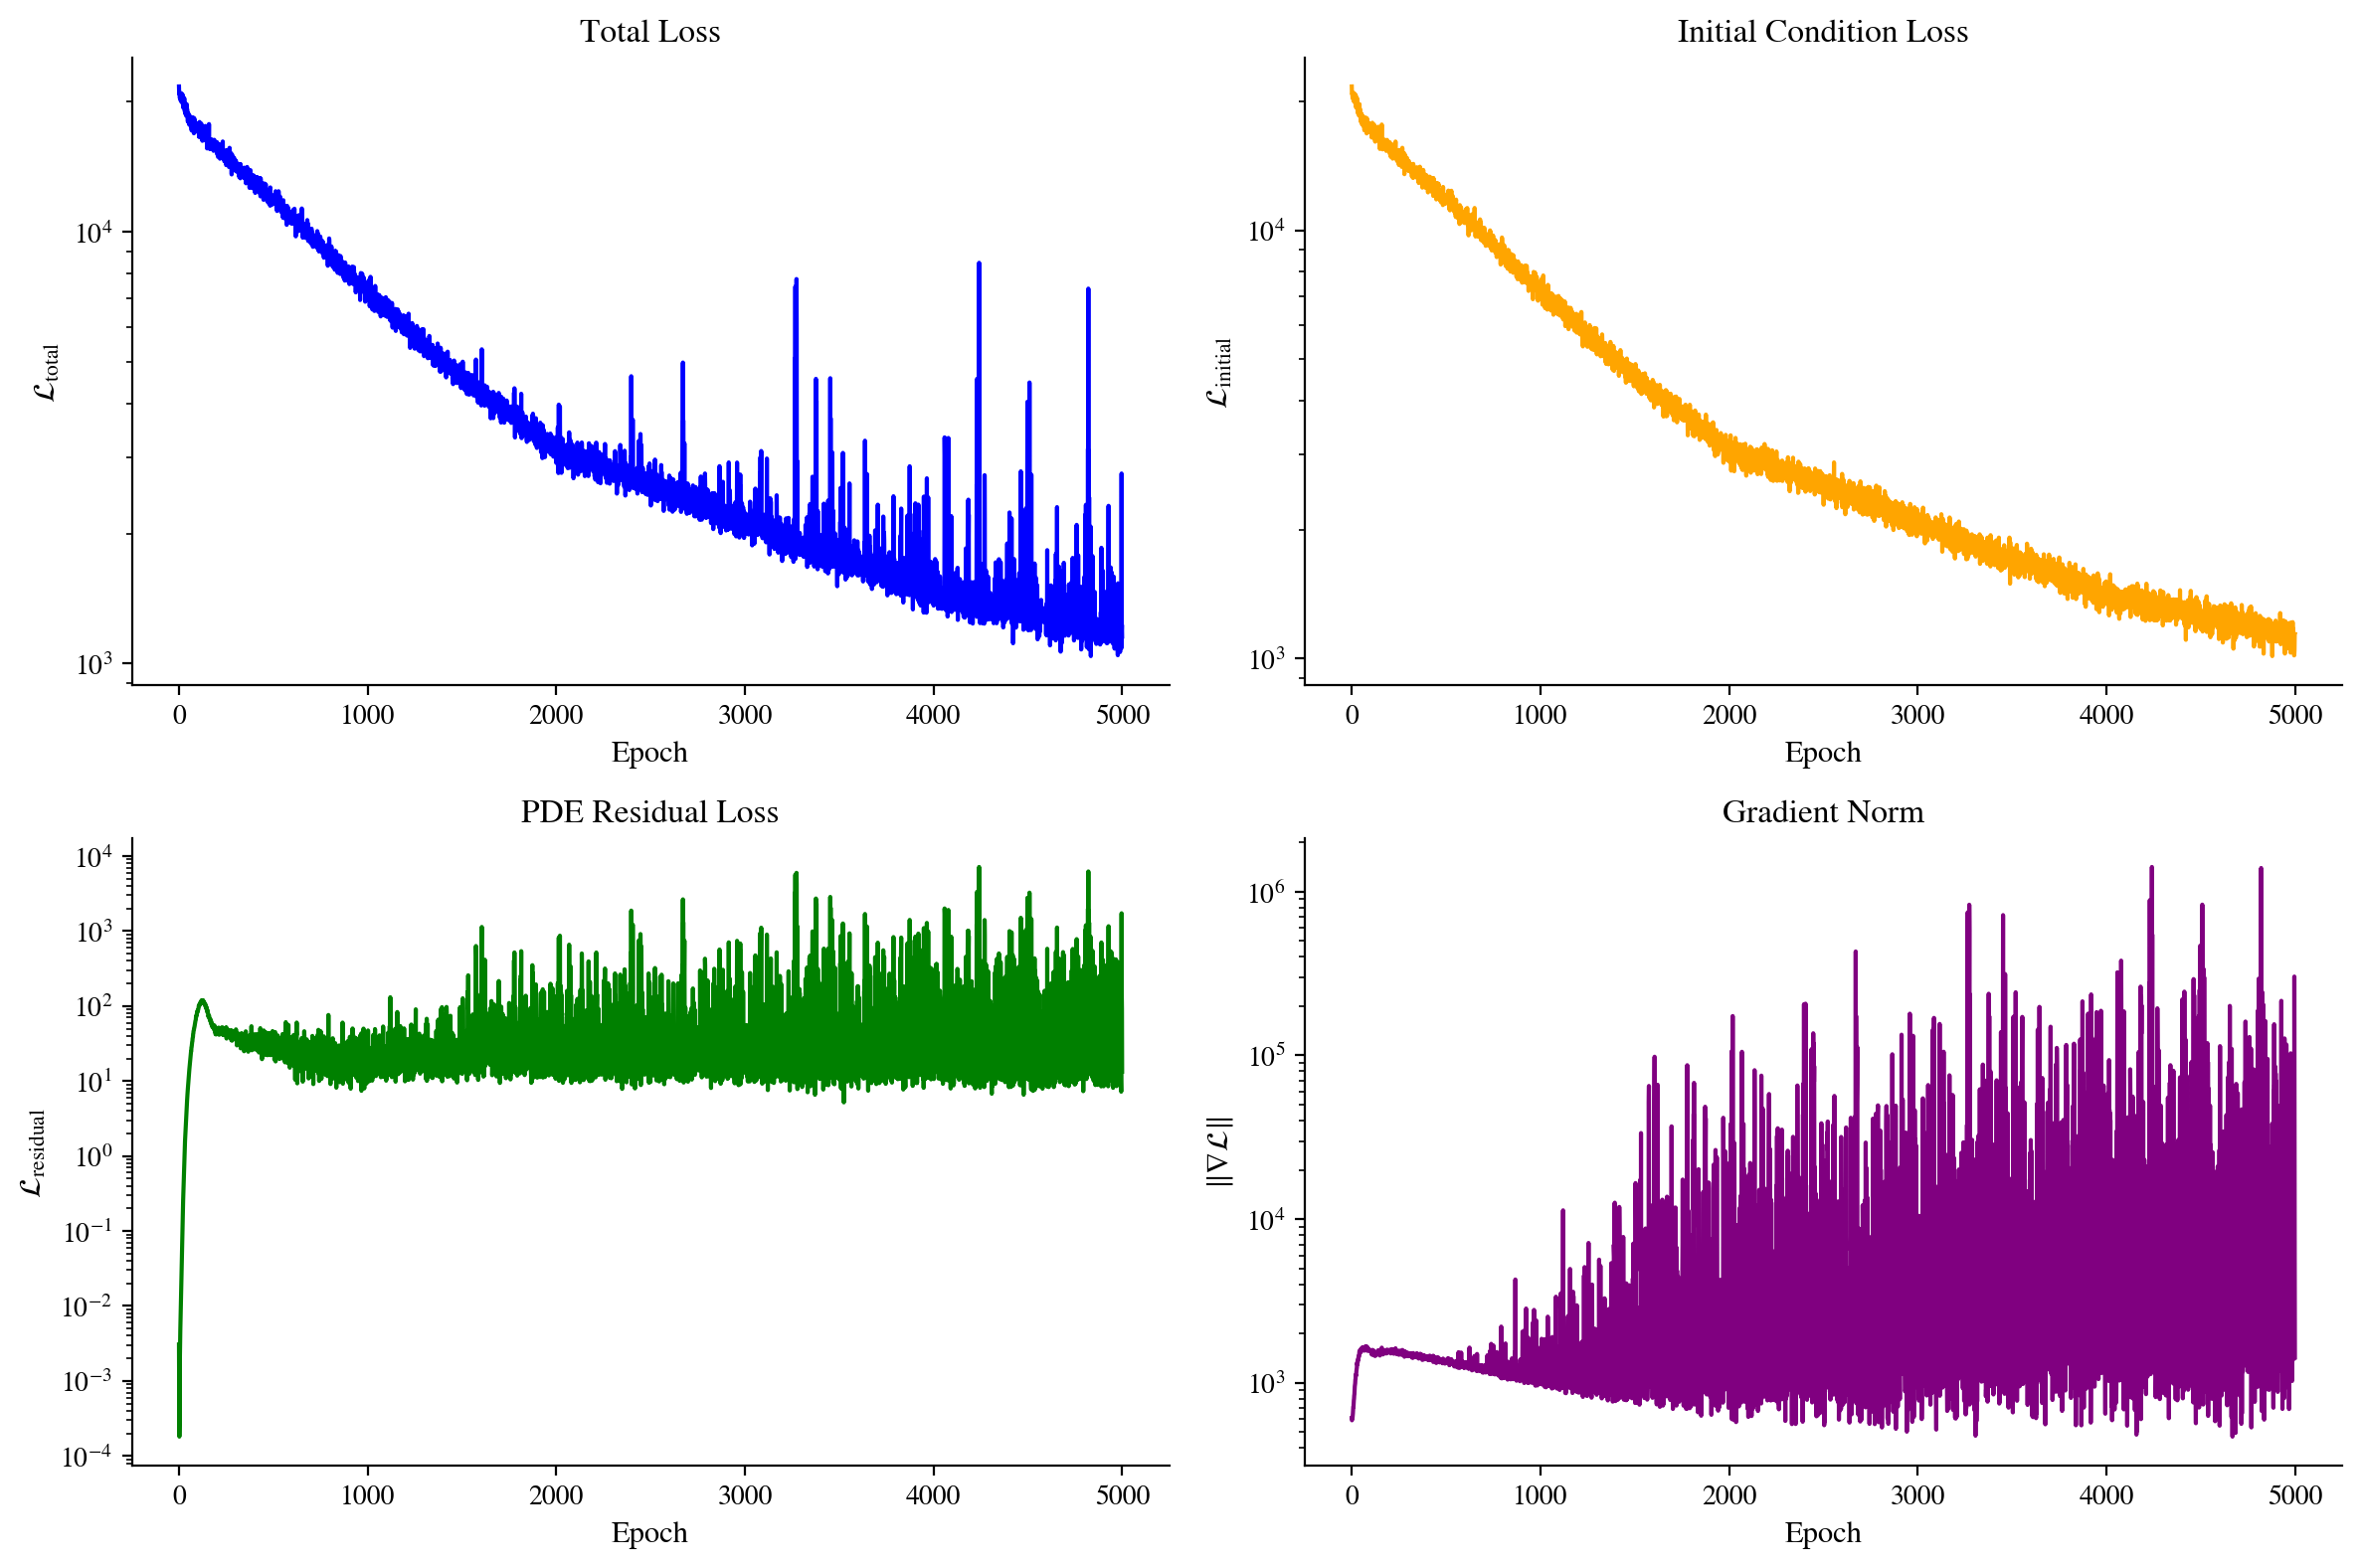


Final Losses:
  Total:    1.1541e+03
  Initial:  1.1408e+03
  Residual: 1.3319e+01


In [8]:
# --- Training history ---
fig = plot_training_history(history_spinn, figsize=(12, 8))
plt.show()

print(f"\nFinal Losses:")
print(f"  Total:    {history_spinn['loss_total'][-1]:.4e}")
print(f"  Initial:  {history_spinn['loss_initial'][-1]:.4e}")
print(f"  Residual: {history_spinn['loss_residual'][-1]:.4e}")

### 3.3 Empirical Score Network $s_\theta$ (DSM)

The empirical score network $s_\theta$ is an MLP mapping $[x, t] \in \mathbb{R}^{d+1}$ to the score vector $s \in \mathbb{R}^d$, trained via the DSM objective derived in §1.2.

**Training data** (`x0_data`): All paths start from the fixed point $x_0$ (point-mass initial condition). To calibrate to real market data, replace `x0_data` with observed log-returns — no other code change is needed.

In [9]:
# --- x0_data: clean starting points (point mass at x0) ---
N_DATA = 4000
x0_data = x0_tensor.unsqueeze(0).expand(N_DATA, -1).clone()  # [N_DATA, d]

print(f"x0_data shape: {x0_data.shape}")
print(f"All rows identical (point-mass IC): {torch.allclose(x0_data[0], x0_data[-1])}")

x0_data shape: torch.Size([4000, 1])
All rows identical (point-mass IC): True


In [10]:
# --- Empirical score network ---
# Architecture: MLP mapping [x, t] → s(x, t) ∈ ℝᵈ
score_net = MLP(
    input_dim=spatial_dim + 1,
    output_dim=spatial_dim,
    hidden_dims=[128, 128, 128],
    activation='tanh',
).to(device)

n_params = sum(p.numel() for p in score_net.parameters())
print(f"Score network parameters: {n_params:,}")

Score network parameters: 33,537


In [11]:
# --- DSM training ---
dsm_config = DSMConfig(
    batch_size=512,
    n_epochs=3000,
    lr=1e-3,
    weight_decay=1e-5,
    lr_decay_step=1500,
    lr_decay_gamma=0.5,
    T=T,
    t_eps=t_eps,
    log_every=500,
)

trainer = DSMTrainer(
    sde=merton_sde,
    score_network=score_net,
    config=dsm_config,
    device=device,
)

history_dsm = trainer.train(x0_data)

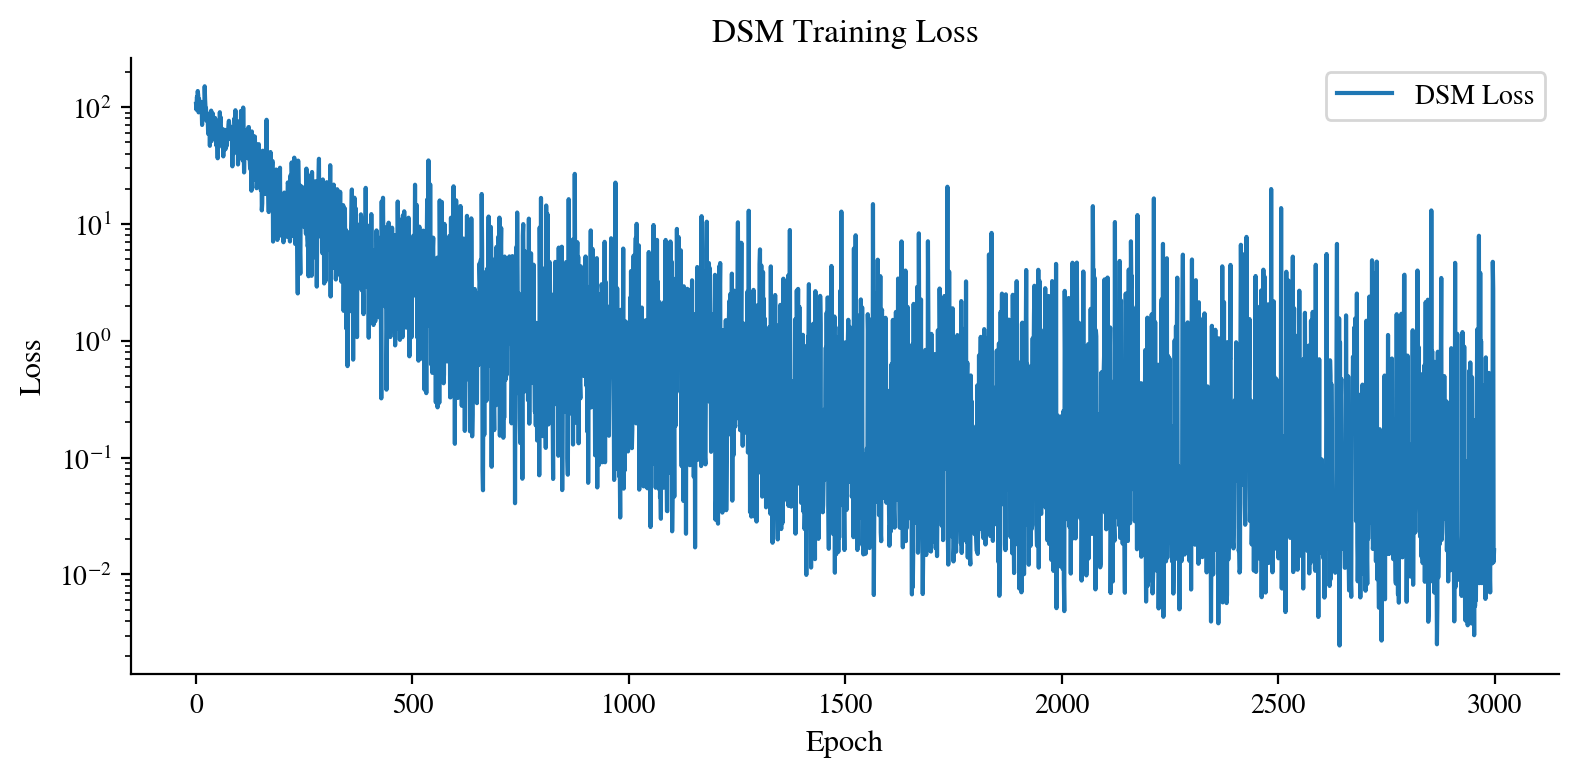

Final DSM loss: 1.6120e-02


In [12]:
# --- Training loss curve ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.semilogy(history_dsm['dsm_loss'], linewidth=1.5, label='DSM Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('DSM Training Loss')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Final DSM loss: {history_dsm['dsm_loss'][-1]:.4e}")

## Part 4: Reverse SDE Validation

### 4.1 Prior Samples

We draw $N$ samples from the terminal prior $p_T = \mathcal{N}(x_0 + \mu T,\, DT)$ to initialise the reverse SDE.

In [13]:
N_SAMPLES = 2000  # samples to generate

# --- Sample from prior p_T = N(x0 + μT, DT) ---
prior_mean_t = torch.tensor(x0 + mu * T, dtype=torch.float32, device=device)
prior_std_t  = torch.tensor(np.sqrt(D * T), dtype=torch.float32, device=device)

torch.manual_seed(1)
x_prior = prior_mean_t + prior_std_t * torch.randn(N_SAMPLES, spatial_dim, device=device)
print(f"Prior samples: mean={x_prior.mean().item():.4f}, std={x_prior.std().item():.4f}")
print(f"Expected     : mean={prior_mean_t.item():.4f}, std={prior_std_t.item():.4f}")

Prior samples: mean=0.0516, std=0.2059
Expected     : mean=0.0500, std=0.2000


### 4.2 Three-Way Comparison

We run the Predictor-Corrector reverse SDE independently with each of the three score functions. All samplers share the same settings and the same initial noise seed for a fair comparison.

In [ ]:
# --- Score functions: signature (x: [B,d], t: [B,1]) → [B,d] ---

def analytical_score_fn(x, t):
    """Ground-truth score: -(Dt)⁻¹(x - x₀ - μt)."""
    return equation.analytical_score(x, t)

def pinn_score_fn(x, t):
    """Score-PINN score s_φ."""
    return score_pinn_solver.predict_score(x, t)

def empirical_score_fn(x, t):
    """Empirical score s_θ via DSM."""
    return trainer.predict_score(x, t)

# --- Sampler settings (shared across all three) ---
SAMPLER_KWARGS = dict(
    n_steps=1000,
    n_corrector_steps=1,
    corrector_step_size=1e-3,
    t_eps=t_eps,
    device=device,
)

In [15]:
# --- Score A: Analytical ---
torch.manual_seed(2)
sampler_analytical = ReverseDiffusionSampler(
    sde=merton_sde, score_fn=analytical_score_fn, **SAMPLER_KWARGS
)
samples_analytical = sampler_analytical.sample(x_prior.clone(), T=T)
print(f"[Analytical]  mean={samples_analytical.mean().item():.4f},  std={samples_analytical.std().item():.4f}  (target x₀={x0[0]})")

[Analytical]  mean=0.0066,  std=0.2478  (target x₀=0.0)


In [ ]:
# --- Score B: Score-PINN ---
torch.manual_seed(2)
sampler_pinn = ReverseDiffusionSampler(
    sde=merton_sde, score_fn=pinn_score_fn, **SAMPLER_KWARGS
)
samples_pinn = sampler_pinn.sample(x_prior.clone(), T=T)
print(f"[Score-PINN s_φ]  mean={samples_pinn.mean().item():.4f},  std={samples_pinn.std().item():.4f}  (target x₀={x0[0]})")

In [17]:
# --- Score C: Empirical s_θ ---
torch.manual_seed(2)
sampler_theta = ReverseDiffusionSampler(
    sde=merton_sde, score_fn=empirical_score_fn, **SAMPLER_KWARGS
)
samples_theta = sampler_theta.sample(x_prior.clone(), T=T)
print(f"[Empirical sθ] mean={samples_theta.mean().item():.4f},  std={samples_theta.std().item():.4f}  (target x₀={x0[0]})")

[Empirical sθ] mean=0.0016,  std=0.0531  (target x₀=0.0)


## Part 5: Results

### 5.1 Generated Samples

Histograms of reverse-SDE generated samples for each score source. Valid samples should concentrate near $x_0 = 0$.

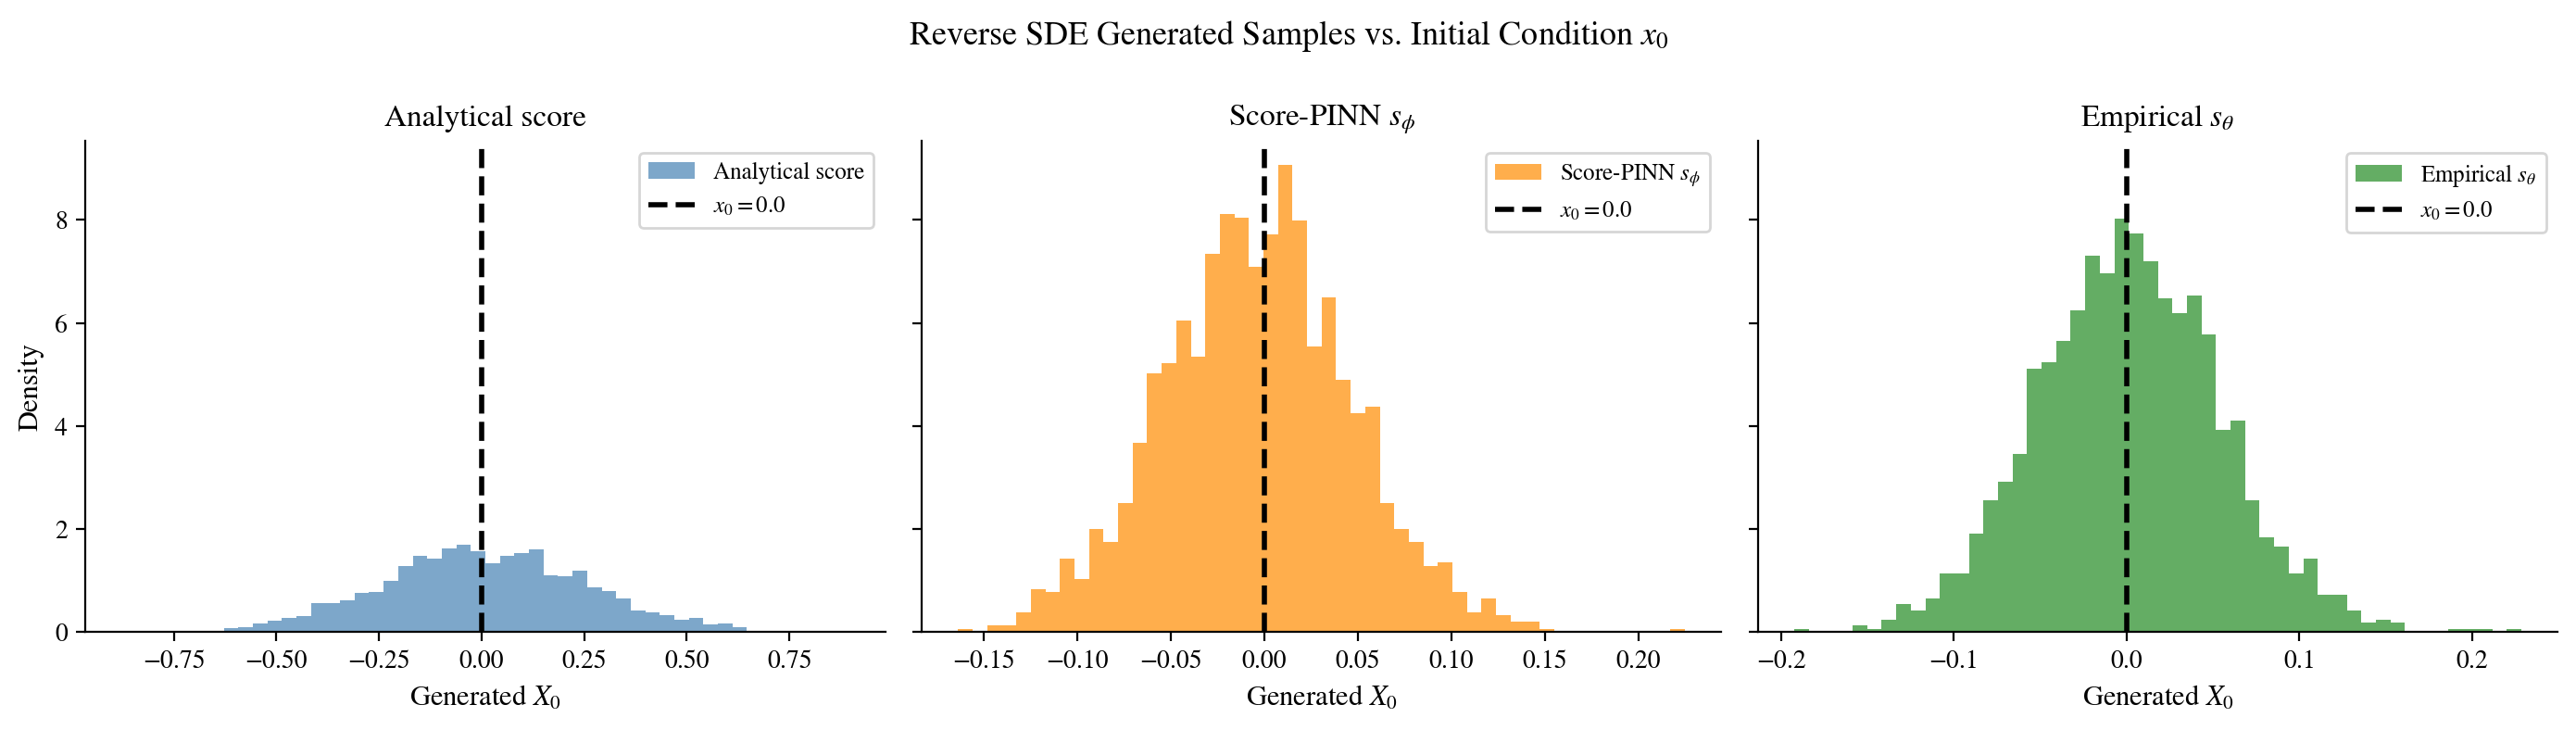

In [18]:
# --- Histogram comparison ---
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

label_pairs = [
    (samples_analytical, 'Analytical score',       'steelblue'),
    (samples_pinn,       'Score-PINN $s_\\phi$',   'darkorange'),
    (samples_theta,      'Empirical $s_\\theta$',  'forestgreen'),
]

for ax, (samples, label, color) in zip(axes, label_pairs):
    s_np = samples[:, 0].cpu().numpy()
    ax.hist(s_np, bins=50, density=True, color=color, alpha=0.7, label=label)
    ax.axvline(x0[0], color='k', lw=2, linestyle='--', label=f'$x_0 = {x0[0]}$')
    ax.set_xlabel('Generated $X_0$')
    ax.set_title(label)
    ax.legend(fontsize=9)

axes[0].set_ylabel('Density')
fig.suptitle('Reverse SDE Generated Samples vs. Initial Condition $x_0$', fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
# --- Quantitative summary ---
print(f"{'Score source':<24} {'Mean':>10} {'Std':>10} {'|Mean - x₀|':>14}")
print("-" * 60)
for samples, label in [
    (samples_analytical, 'Analytical'),
    (samples_pinn,       'Score-PINN sφ'),
    (samples_theta,      'Empirical sθ'),
]:
    s_np = samples[:, 0].cpu().numpy()
    mean = s_np.mean()
    std  = s_np.std()
    err  = abs(mean - x0[0])
    print(f"{label:<24} {mean:>10.4f} {std:>10.4f} {err:>14.4f}")

### 5.2 Score MSE

Mean squared error between each learned score and the analytical ground truth, sampled uniformly over $[x_{\min}, x_{\max}]$ at several time points.

In [20]:
# --- Score MSE vs analytical score across time ---
eval_times = [0.1, 0.3, 0.5, 0.7, 1.0]
n_eval = 2000

x_eval = torch.rand(n_eval, spatial_dim, device=device) * (x_max - x_min) + x_min

rows = []
for t_val in eval_times:
    t_eval = torch.full((n_eval, 1), t_val, device=device)
    s_true = equation.analytical_score(x_eval, t_eval)
    s_pinn = score_pinn_solver.predict_score(x_eval, t_eval)
    s_th   = trainer.predict_score(x_eval, t_eval)

    def mse(a, b):
        return ((a - b) ** 2).sum(dim=-1).mean().item()

    rows.append({
        't':              t_val,
        'Score-PINN MSE': mse(s_pinn, s_true),
        'Empirical MSE':  mse(s_th,   s_true),
    })

print(f"{'t':>6} {'Score-PINN MSE':>16} {'Empirical MSE':>16}")
print("-" * 40)
for r in rows:
    print(f"{r['t']:>6.2f} {r['Score-PINN MSE']:>16.4e} {r['Empirical MSE']:>16.4e}")

     t   Score-PINN MSE    Empirical MSE
----------------------------------------
  0.10       1.1340e+03       6.5018e+03
  0.30       8.4495e-01       4.5991e+01
  0.50       9.7551e-02       1.1004e+00
  0.70       3.5050e-02       2.5980e-01
  1.00       2.6292e-02       4.6066e-02


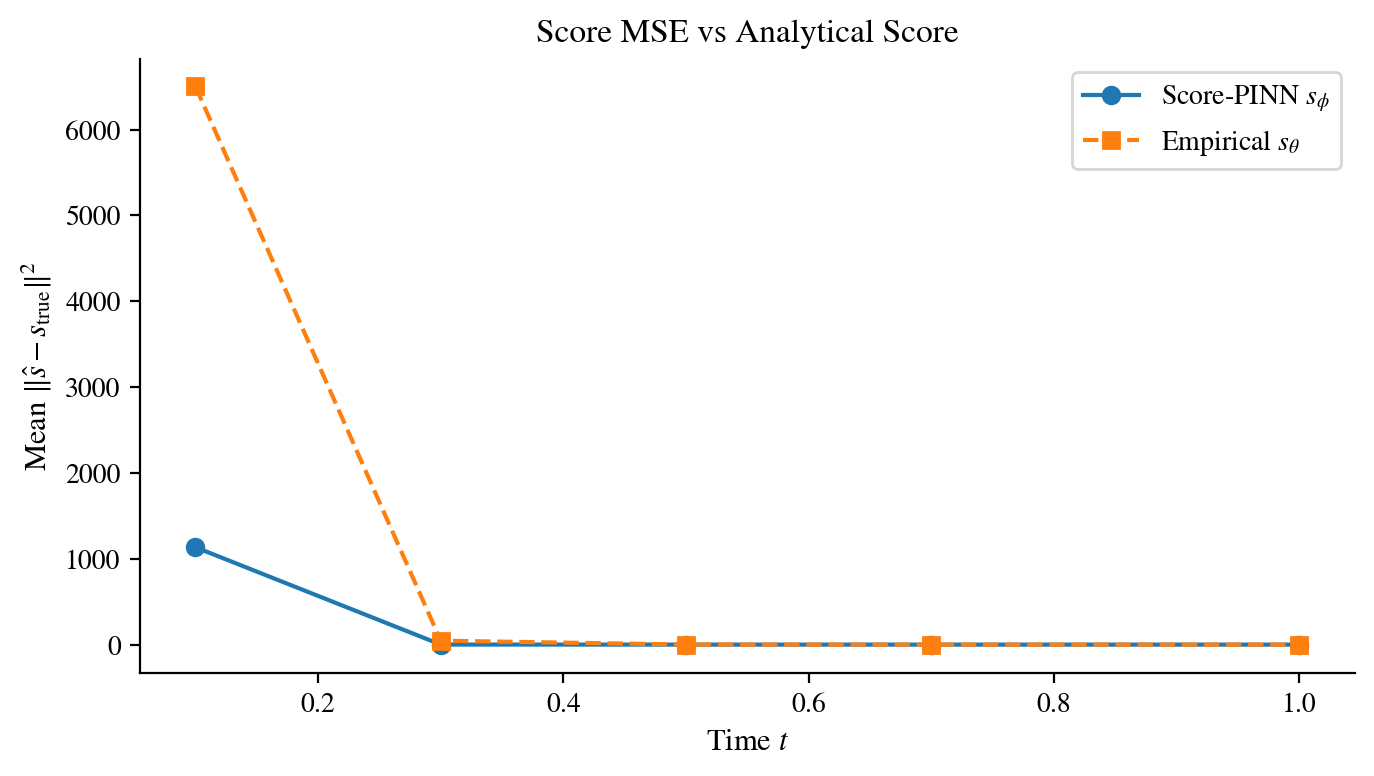

In [21]:
# --- Score MSE plot over time ---
fig, ax = plt.subplots(figsize=(7, 4))
ts = [r['t'] for r in rows]
ax.plot(ts, [r['Score-PINN MSE'] for r in rows], 'o-',  label='Score-PINN $s_\\phi$')
ax.plot(ts, [r['Empirical MSE']  for r in rows], 's--', label='Empirical $s_\\theta$')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'Mean $\|\hat{s} - s_{\mathrm{true}}\|^2$')
ax.set_title('Score MSE vs Analytical Score')
ax.legend()
plt.tight_layout()
plt.show()

---

## References

1. Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2021). Score-based generative modeling through stochastic differential equations. *ICLR 2021*. https://arxiv.org/abs/2011.13456